# Analysis of NYC Motor Vehicle Collisions

This notebook analyzes the enriched NYC motor vehicle collision data from `crashes.parquet`. The goal is to understand the relationship between public holidays and traffic incidents.

In [13]:
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns

# Set plot style for better aesthetics
sns.set_theme(style="whitegrid")

In [14]:
# Load the enriched dataset
try:
    df = pl.read_parquet("crashes.parquet")
    print("Successfully loaded crashes.parquet")
    print(f"Dataset contains {df.height:,} rows.")
except FileNotFoundError:
    print("Error: crashes.parquet not found.")
    print("Please run 'main.py' first to generate the file.")
    df = None

Successfully loaded crashes.parquet
Dataset contains 2,208,114 rows.


## 1. Comparison of Crashes on Holidays vs. Non-Holidays

First, let's get a high-level overview by comparing the total number of crashes that occurred on a public holiday versus a regular day.

Crash counts (Holiday vs. Non-Holiday):
shape: (2, 2)
┌────────────┬─────────┐
│ IS_HOLIDAY ┆ count   │
│ ---        ┆ ---     │
│ bool       ┆ u32     │
╞════════════╪═════════╡
│ false      ┆ 2134129 │
│ true       ┆ 73985   │
└────────────┴─────────┘


/var/folders/4m/296ft7p53dl19s0rtw8dkp180000gp/T/ipykernel_47826/95401866.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


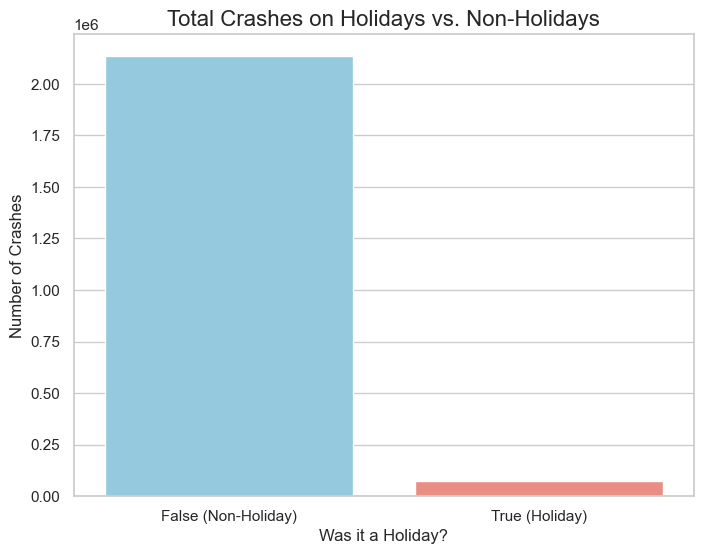

In [15]:
if df is not None:
    # Use value_counts() on the boolean column for a quick summary
    holiday_counts = df.get_column("IS_HOLIDAY").value_counts()
    print("Crash counts (Holiday vs. Non-Holiday):")
    print(holiday_counts)

    # Visualize the comparison
    plt.figure(figsize=(8, 6))
    sns.barplot(
        x=holiday_counts["IS_HOLIDAY"],
        y=holiday_counts["count"],
        palette=["skyblue", "salmon"]
    )
    plt.title("Total Crashes on Holidays vs. Non-Holidays", fontsize=16)
    plt.xlabel("Was it a Holiday?", fontsize=12)
    plt.ylabel("Number of Crashes", fontsize=12)
    plt.xticks([0, 1], ["False (Non-Holiday)", "True (Holiday)"])
    plt.show()

## 2. Top Holidays for Crashes (Year-Agnostic)

Next, we want to identify which specific holidays see the most crashes. To do this, we'll look at the data year-agnostically, meaning we'll group crashes by the month and day of the holiday, regardless of the year it occurred.

Top 10 Holidays with the Most Crashes (All Years Combined):
shape: (10, 3)
┌───────────┬────────────────────┬─────────────┐
│ MONTH_DAY ┆ name               ┆ crash_count │
│ ---       ┆ ---                ┆ ---         │
│ str       ┆ str                ┆ u32         │
╞═══════════╪════════════════════╪═════════════╡
│ 05/08     ┆ Truman Day         ┆ 6110        │
│ 02/12     ┆ Lincoln's Birthday ┆ 5570        │
│ 07/04     ┆ Independence Day   ┆ 3844        │
│ 11/11     ┆ Veterans Day       ┆ 3728        │
│ 01/01     ┆ New Year's Day     ┆ 3486        │
│ 12/25     ┆ Christmas Day      ┆ 2633        │
│ 03/29     ┆ Good Friday        ┆ 1500        │
│ 04/18     ┆ Good Friday        ┆ 1406        │
│ 03/30     ┆ Good Friday        ┆ 1160        │
│ 04/19     ┆ Good Friday        ┆ 1102        │
└───────────┴────────────────────┴─────────────┘


/var/folders/4m/296ft7p53dl19s0rtw8dkp180000gp/T/ipykernel_47826/2813772483.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


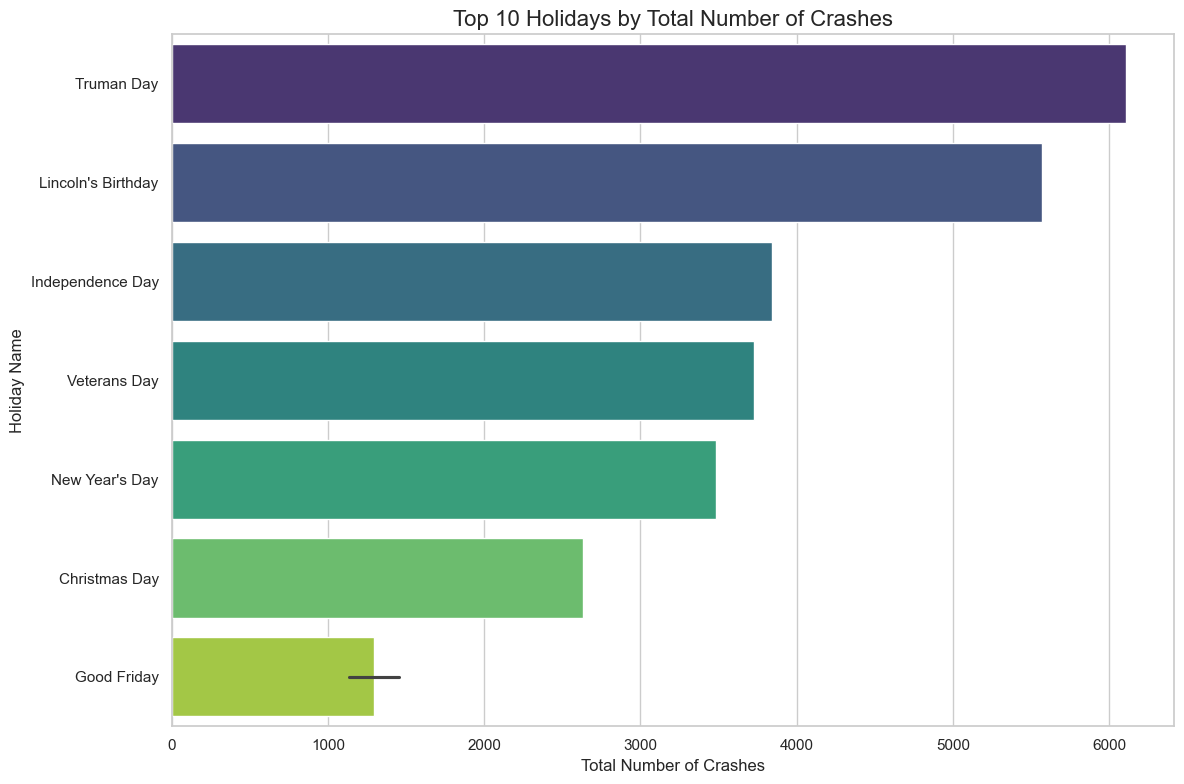

In [16]:
if df is not None:
    # Filter for crashes that occurred on a holiday
    holidays_only_df = df.filter(pl.col("IS_HOLIDAY"))

    # Create a year-agnostic date column (MM/DD) and aggregate
    # We group by both month/day and the holiday name to handle cases
    # where a date might have different holiday names in different contexts (rare).
    top_holidays = (
        holidays_only_df
        .with_columns(
            pl.col("CRASH DATE").str.slice(0, 5).alias("MONTH_DAY")
        )
        .group_by(["MONTH_DAY", "name"])
        .agg(
            pl.len().alias("crash_count")
        )
        .sort("crash_count", descending=True)
    )

    print("Top 10 Holidays with the Most Crashes (All Years Combined):")
    print(top_holidays.head(10))

    # Visualize the top 10
    plt.figure(figsize=(12, 8))
    sns.barplot(
        data=top_holidays.head(10).to_pandas(),
        y="name",
        x="crash_count",
        palette="viridis",
        orient="h"
    )
    plt.title("Top 10 Holidays by Total Number of Crashes", fontsize=16)
    plt.xlabel("Total Number of Crashes", fontsize=12)
    plt.ylabel("Holiday Name", fontsize=12)
    plt.tight_layout()
    plt.show()